# Objective
***
This dataset is from a bank whose main objective is to convert its regular customers into personal loan customers while retaining them as depositors. The data is a marketing campaign that the bank did for personal loans. We will be looking at what common traits do bank customers have when they take out a personal loan. We will then leverage that information to build a predictive model that will be able to predict who are our potential personal loan customers.
## Project Workflow
This notebook will be divided into 6 different parts:
1. We will explore the data and clean up any missing values or inconsistencies. *This step is important, because in order for our machine learning algorithms to work / have meaningful results, the data must be thoroughly cleaned*. We will be utilizing `pandas`, `matplotlib`, and `seaborn` to achieve this.
2. At this stage we will preprocess our data for our machine learning algorithm. This usually means scaling the data and partitioning our data into train and test splits to prepare it for our model. `Scikit-learn` will be used heavily at this stage.
3. A baseline model will be used, in this case we will start with `Logistic Regression`. *This will be the model that subsequent models will be compared too*.
4. With the information received from our previous model we will build our final model a `Decision Tree`.
5. Finally we will report our findings and package our model with `pickle` to be deployed on an api using `Flask`
***
## Column Info
* ID: Customer ID
* Age: Customer Age
* Experience: Number of years of professional experience
* Income: Annual income of the customer (thousands)
* ZIP Code = Home Address ZIP code
* Family: Family size of the customer
* CCAvg: Avg. spending on credit cards per month (thousands)
* Education Level: 1=Undergrad, 2=Graduate, 3=Advanced/Professional
* Mortgage: Value of house mortgage if any (thousands)
* Personal Loan: Did this customer accept the personal loan during the last campaign
* Securities Account : 1=they have one with the bank, 0=no
* CD Account: 1=they have one with the bank, 0=no
* Online: whether they use the online banking services
* Credit Card: 1=they have one with the bank, 0=no

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import auc
import pickle

In [2]:
df = pd.read_csv("C:/Users/Wombat/data/bank_loan.csv")

   ID  Age  Experience  Income  ZIP Code  Family  CCAvg  Education  Mortgage  \
0   1   25           1      49     91107       4    1.6          1         0   
1   2   45          19      34     90089       3    1.5          1         0   
2   3   39          15      11     94720       1    1.0          1         0   
3   4   35           9     100     94112       1    2.7          2         0   
4   5   35           8      45     91330       4    1.0          2         0   

   Personal Loan  Securities Account  CD Account  Online  CreditCard  
0              0                   1           0       0           0  
1              0                   1           0       0           0  
2              0                   0           0       0           0  
3              0                   0           0       0           0  
4              0                   0           0       0           1  


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (tot

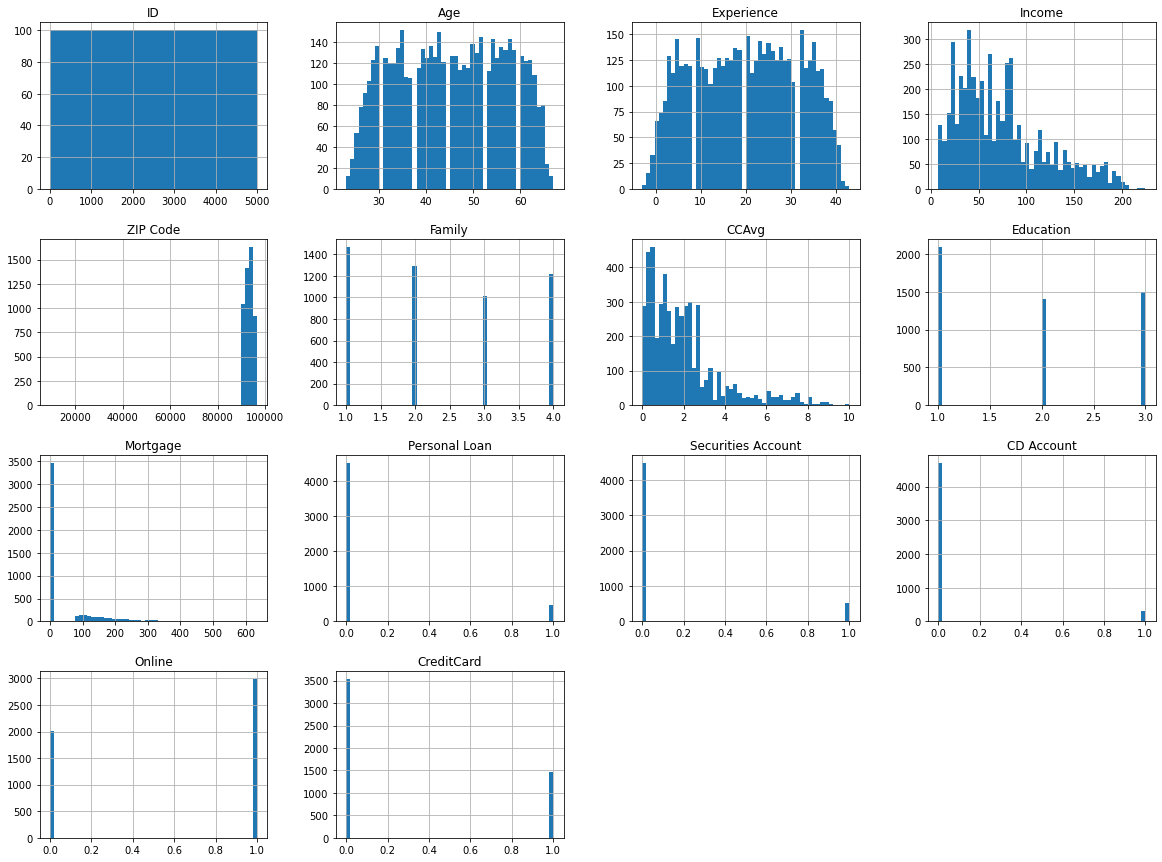

In [3]:
new_df = df.copy()
print(new_df.head())
print("\n")
print(new_df.info())
print("\n")
print(new_df.describe())
%matplotlib inline
new_df.hist(bins=50, figsize=(20,15));

***
### Initial Findings
- Fortunately we do not have any missing values.
- The data still needs to be cleaned somewhat. 
- The distribution for CCAvg, and income is skewed to the right.
- Our target variable "Personal Loan" is highly imbalanced. We have much more 0 observations than 1's.

### Looking for Correlations
- We will now look for variable's that are correlated with our target variable personal loans. 
- This helps us weed out the irrelevant variables and allows us to focus on the ones that offer the most help in predicting personal loans.
- One useful way to look for correlations is through the use of a correlation heatmap
***

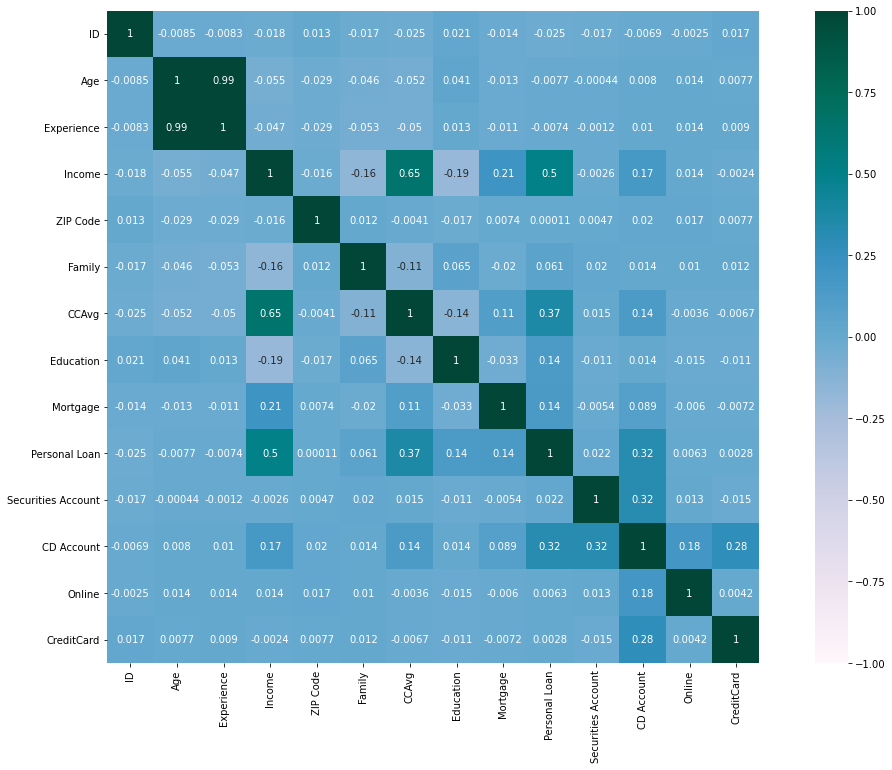

In [4]:
plt.figure(figsize=(20,12))
sns.heatmap(new_df.corr(), annot=True, square=True, vmin=-1, vmax=1, center=0, cmap="PuBuGn");

***
### Heatmap Explanation
- This is a heatmap that uses the standard correlation coefficient (Pearson's r) to show the linear correlation between all of over variables. The range is from -1 to 1. A number close to 1 means there is a strong positive correlation. Close to -1 means there is a strong negative correlation.
- The variables that are most closely related to "Personal Loan" are Income(0.50), CCAvg(0.37), Education(0.14), Mortgage(0.14), and CD Account(0.32).
- As a side note experience also seems to be highly correlated with age, so we may be able to drop one of them.

# 2. Data pre-processing
- At this stage we will drop the variables we do not need and separating our variable of interest (personal_loan) from the rest of the data.
- You generally want to separate the data into a `training` and `test` set. You "fit" the algorithm to the training set then you use the test set as a benchmark of how the algorithm will do with data it has never seen before. By default the test set size using train_test_split is 0.25 of the data.
- Also, standardizing our data is a pretty common step we have to do before we run our algorithm. Due to the skewness of our data and because it contains some outliers I have decided to use the `RobustScaler` from scikit-learn.  
- In addition to `RobustScaler` we will also be using the `Pipeline` function for a better more streamlined workflow. `Pipeline` also prevents unwanted data leakage from occuring (sharing information between the training and test datasets).

In [5]:
# Separating variables
rev_df = df.copy()
X = rev_df.drop(["ID", "Experience", "ZIP Code", "Personal Loan"], axis=1)
Y = rev_df["Personal Loan"]

# Splitting data into train and test splits
x_train, x_test, y_train, y_test = train_test_split(X,Y, stratify=Y,random_state=2)

# Using pipelines
log_pipeline = Pipeline([("scaler", RobustScaler()),
                        ("logistic", LogisticRegression())])

tree_pipeline = Pipeline([("scaler", RobustScaler()),
                         ("tree", DecisionTreeClassifier())])

*** 
### Hyper-parameter tuning
- Scikit-learns estimators have hyper-parameters that one can tune to fit the data. An easy way to find the optimal hyper-parameters is to use `GridSearchCV`. We will be using this for both of our models.
***

# 3. Logistic Regression
- Our primary objective is to try and predict the customers who will take out a personal loan. To achieve this goal we will be using scikit-learn's default logistic regression which has regularization set to on. Regularization will help ensure that our model will not overfit the data giving us a more reliable model to predict which new customers will take out a personal loan.
- We will keep the variables that are correlated the most with personal loans and dropping the rest. Most notably we will be getting rid of experience since it is highly correlated with age therefore we do not need to have both of them.
- Logistic regression is a common regression algorithm used to estimate the probability that an observation belongs to a particular class. In our case our two classes are people who have taken out a personal loan and people who have not. If the estimated probability is greater than 50% then the model predicts the observation belongs to that class (people who take out personal loans).
- It's important to remember that scikit-learn's logistic regression applies regularization by default. This poses a problem for explanatory model building where your interest is in explaining the relationship between the predictors and the target variable. However, for our purpose of making a predictive model this poses no problem. 

In [6]:
logistic_params = {"logistic__penalty": ['l2', 'none'],
                  "logistic__class_weight": ["None", "balanced"]}

grid_logistic = GridSearchCV(log_pipeline, param_grid=logistic_params, scoring="recall")
grid_logistic.fit(x_train, y_train)
grid_logistic.best_estimator_.get_params()

{'memory': None,
 'steps': [('scaler', RobustScaler()),
  ('logistic', LogisticRegression(class_weight='balanced'))],
 'verbose': False,
 'scaler': RobustScaler(),
 'logistic': LogisticRegression(class_weight='balanced'),
 'scaler__copy': True,
 'scaler__quantile_range': (25.0, 75.0),
 'scaler__with_centering': True,
 'scaler__with_scaling': True,
 'logistic__C': 1.0,
 'logistic__class_weight': 'balanced',
 'logistic__dual': False,
 'logistic__fit_intercept': True,
 'logistic__intercept_scaling': 1,
 'logistic__l1_ratio': None,
 'logistic__max_iter': 100,
 'logistic__multi_class': 'auto',
 'logistic__n_jobs': None,
 'logistic__penalty': 'l2',
 'logistic__random_state': None,
 'logistic__solver': 'lbfgs',
 'logistic__tol': 0.0001,
 'logistic__verbose': 0,
 'logistic__warm_start': False}

In [7]:
log_pipeline_2 = Pipeline([("scaler", RobustScaler()),
                        ("logistic", LogisticRegression(class_weight="balanced"))])
log_pipeline_2.fit(x_train, y_train)
y_pred = log_pipeline_2.predict(x_test)
y_pred_prob = log_pipeline_2.predict_proba(x_test)

***
### Assumptions
- There are many metrics we can use to measure our models performance. **I'm going to operate under the assumption that we want to find as many people who will take out personal loans (the 1's)**. Since, our class of interest is so rare in this dataset (about 9%). We will primarily be concerned with our "recall" and "Precision" metric. 
- "Recall" measures the proportion of 1's that our model correctly predicts: TruePositives / (TruePositives + FalseNegatives)
- "Precision" measures the accuracy of a predicted positive outcome: TruePositives / (TruePositives + FalsePositives)
- Precision and recall are normally tradeoffs you can almost never have a model with a high precision and high recall. You can make a model with a high recall/precision but you would have to sacrifice the other metric to achieve this.
- Both of these metrics can be plotted together to form a precision-recall curve. This curve is an effective diagnostic tool for imbalanced classification models.
- The area under this curve is called the area under the curve or AUC for short. This is simply the total area under the curve, the larger the AUC value the more effective the classifier with an AUC of 1 being a perfect classifier.
***

              precision    recall  f1-score   support

           0       0.99      0.90      0.94      1130
           1       0.48      0.92      0.63       120

    accuracy                           0.90      1250
   macro avg       0.74      0.91      0.79      1250
weighted avg       0.94      0.90      0.91      1250

[[1012  118]
 [  10  110]]
0.8063512720351016


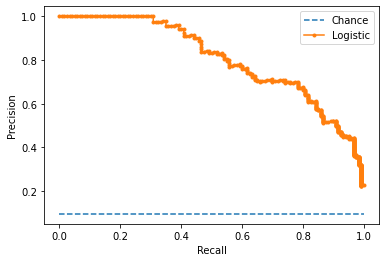

In [8]:
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

prob = y_pred_prob[:, 1]
chance = len(Y[Y==1])/len(Y)
plt.plot([0,1], [chance, chance], linestyle="--", label="Chance");
precision, recall, _ = precision_recall_curve(y_test, prob)
plt.plot(recall, precision, marker=".", label="Logistic");
print(auc(recall, precision))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend();

***
# Findings
- As we can see we only got a recall of 0.92 for the positive class (1) which means that we were able to correctly find about 92% of the people who got a personal loan.
- Meanwhile, our precision for the positive class (1) is only a 0.48. This means that if we classify a person as someone who will want to apply for a personal loan, there is a 52% chance that we are wrong about the classification.
- Finally, we only got an AUC of 0.80 so there are definitely some improvements we can make.
***

# 4. Decision Tree
- Decision trees are some of the most popular algorithms used for classication and regression tasks today. You can think of a tree model as a set of "if-then-else" rules. The great thing about tree models is their ability too discover hidden patterns in data that sometimes even linear and logistic regression cannot uncover.
- One difficulty of using decision trees is that they need to be configured in order to give you the best predictive power possible without overfitting the data. To achieve this we will use scikit learns `GridSearchCV`, this will give us the optimal configuration to use for our specific data.

In [9]:
tree_parameters = {"tree__criterion":["gini", "entropy"], "tree__max_depth":[2,4,6,8,10,12], "tree__min_samples_leaf":[1,2,3,4,5,6,7,8,9,10]}
tree_gc = GridSearchCV(tree_pipeline, tree_parameters)
tree_gc.fit(x_train,y_train)
tree_gc.best_estimator_.get_params()

{'memory': None,
 'steps': [('scaler', RobustScaler()),
  ('tree',
   DecisionTreeClassifier(criterion='entropy', max_depth=8, min_samples_leaf=2))],
 'verbose': False,
 'scaler': RobustScaler(),
 'tree': DecisionTreeClassifier(criterion='entropy', max_depth=8, min_samples_leaf=2),
 'scaler__copy': True,
 'scaler__quantile_range': (25.0, 75.0),
 'scaler__with_centering': True,
 'scaler__with_scaling': True,
 'tree__ccp_alpha': 0.0,
 'tree__class_weight': None,
 'tree__criterion': 'entropy',
 'tree__max_depth': 8,
 'tree__max_features': None,
 'tree__max_leaf_nodes': None,
 'tree__min_impurity_decrease': 0.0,
 'tree__min_impurity_split': None,
 'tree__min_samples_leaf': 2,
 'tree__min_samples_split': 2,
 'tree__min_weight_fraction_leaf': 0.0,
 'tree__presort': 'deprecated',
 'tree__random_state': None,
 'tree__splitter': 'best'}

In [10]:
tree_pipeline_2 = Pipeline([("scaler", RobustScaler()),
                         ("tree", DecisionTreeClassifier(criterion="entropy", class_weight="balanced",max_depth=4, min_samples_leaf=1))])
tree_pipeline_2.fit(x_train, y_train)
y_pred_tree = tree_pipeline_2.predict(x_test)
y_pred_prob_tree = tree_pipeline_2.predict_proba(x_test)

              precision    recall  f1-score   support

           0       1.00      0.96      0.98      1130
           1       0.70      0.97      0.81       120

    accuracy                           0.96      1250
   macro avg       0.85      0.96      0.90      1250
weighted avg       0.97      0.96      0.96      1250

[[1081   49]
 [   4  116]]
0.9788678025840805


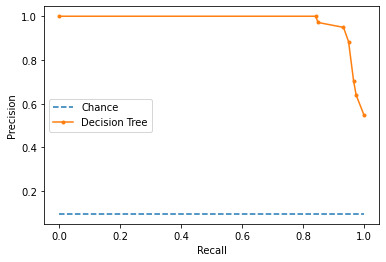

In [11]:
print(classification_report(y_test, y_pred_tree))
print(confusion_matrix(y_test, y_pred_tree))

prob_tre = y_pred_prob_tree[:, 1]
chance = len(Y[Y==1])/len(Y)
plt.plot([0,1], [chance, chance], linestyle="--", label="Chance");
precision_tre, recall_tre, _ = precision_recall_curve(y_test, prob_tre)
plt.plot(recall_tre, precision_tre, marker=".", label="Decision Tree");
print(auc(recall_tre, precision_tre))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend();

***
### Findings
- Our recall for the positive class (1) increased to 0.97 a 5% increase. Our model was able to correctly identify 97% of all people who took out a personal loan.
- Our precision for the positive class (1) also increased to 0.70 a 22% increase.
- Finally our AUC increased to 0.97, this model is substantially better than our last one!
***

# 5. Business Application & Deployment
- This model could be used to help inform the business on who may be a good candidate to target with a personal loan campaign.
- In this notebook I made the explicit assumption that the business wanted to detect as many customers who would be ideal for a personal loan offer. In reality this assumption may not always hold true. 
- Consider the cost of having marketing send the customer a personal loan offer who does not want one (false positive error). One can compare this to the cost of marketing missing a customer who would have applied for a personal loan (false negative). When making a classifier one should estimate the cost or benefit of each decision the classifier can make and adjust accordingly to suit the specific business needs. 
- Additionally, this model had only 5,000 observations which is not that much by machine learning standards. If we were somehow able to get more data to fit the model it definitely would be able to improve in how it selects customers for personal loans.

In [12]:
pickle.dump(tree_pipeline_2, open('model.pkl','wb'))